<a href="https://colab.research.google.com/github/ysj9909/GANs/blob/main/AC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision.utils import save_image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Hyper-parameters
batch_size = 100
latent_dim = 100
num_classes = 10
learning_rate = 0.0002
num_epochs = 200

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(root = "./data", train = True, download = True,
                                             transform = transforms.Compose([transforms.ToTensor(),
                                                                             transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))
dataloader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size  = batch_size ,
                                         shuffle = True, num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


학습용 이미지 몇 개를 살펴보자.

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


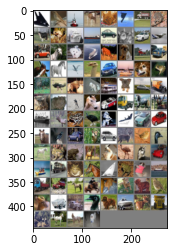

plane  bird  ship horse   cat plane truck  frog   dog  frog  ship  ship   car   cat   car plane   car horse   dog  ship  deer   dog plane   car horse horse  bird  bird   car  ship   dog  frog  deer  bird  deer   dog  ship   dog   car truck   cat   cat  bird horse   car truck horse  deer  ship  deer  frog  bird horse plane   car   car horse  bird   car  deer   car  deer  bird  bird horse  frog  frog  deer   cat  bird   dog   car  ship truck  frog horse  ship  frog   dog  ship truck truck horse horse   cat   dog   dog  bird  deer truck   car  bird   dog  ship  deer truck  deer horse horse   dog


In [ ]:
# 이미지를 보여주기 위한 함수
def imshow(img):
  img = img / 2 + .5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# 학습용 이미지를 무작위로 가져오기.
dataiter = iter(dataloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 레이블 출력하기
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

모델 정의

In [ ]:
def make_one_hot(idx_list, num_classes = 10):
  one_hot = torch.zeros(idx_list.size(0), num_classes)
  for i, idx in enumerate(idx_list):
    one_hot[i][idx] = 1
  return one_hot

In [ ]:
class Generator(nn.Module):
  def __init__(self, num_classes = 10):
    super(Generator, self).__init__()

    def Block(in_channels, out_channels, stride = 2,padding = 1,  normalize  = True, relu = True):
      module_list = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = stride,padding = padding, bias = False)]
      if normalize :
        module_list.append(nn.BatchNorm2d(out_channels))
      if relu:
        module_list.append(nn.ReLU(inplace = True))

      return module_list
    self.fc = nn.Linear(latent_dim + num_classes, 384)
    self.relu = nn.ReLU(inplace = True)

    self.upsample_model = nn.Sequential(
        *Block(384, 192, 1, 0) ,    # (batch_size, 192, 4, 4)
        *Block(192, 96), # (batch_size, 96, 8, 8)
        *Block(96, 48), # (batch_size, 48, 16, 16)
        *Block(48, 3, normalize = False, relu = False), # (batch_size, 3, 32, 32)
        nn.Tanh()

    )

  def forward(self, z, c):
    '''
    z : latent vector, shape of (batch_size, latent_dim)
    c = class labels,  shape of (batch_size, num_classes)
    '''
    conditioned_z = torch.cat([z, c], dim = -1)     # (batch_size, latent_dim + num_classes)
    out = self.relu(self.fc(conditioned_z))
    out = out.unsqueeze(2).unsqueeze(3)     # for input form of transposed Conv layer

    generated_imgs = self.upsample_model(out)
    return generated_imgs


In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    def Block(in_channels, out_channels, stride, normalize = True):
      module_list = [nn.Conv2d(in_channels, out_channels,kernel_size= 3, stride = stride, padding = 1, bias = False),
                     nn.Dropout(0.5),]
      if normalize : 
        module_list.append(nn.BatchNorm2d(out_channels))
      module_list.append(nn.LeakyReLU(0.2, inplace = True))
      return module_list


    self.model = nn.Sequential(
        *Block(3, 16, 2, normalize = False),   # (batch_size, 16, 16, 16)
        *Block(16, 32, 1),
        *Block(32, 64, 2),   # (batch_size, 64, 8, 8)
        *Block(64, 128, 1),
        *Block(128, 256, 2),   # (batch_size, 256, 4, 4)
        *Block(256, 512, 2),   # (batch_size, 512, 2, 2)
    )
    self.fc = nn.Linear(2048, 11)

  def forward(self, imgs):
    # imgs, shape of (batch_size, 3, 32, 32)
    # class labels, shape of (batch_size, num_classes)
    batch_size = imgs.size(0)
    
    output = self.model(imgs)
    output = output.view(batch_size, -1)    # (batch_size, 2048)
    output = self.fc(output)    # (batch_size, 11)
    
    class_prob = output[:, :10]    # P(C = c | X)
    real_prob = torch.sigmoid(output[:, -1]).unsqueeze(-1)      # P(S = real | X)
    return real_prob, class_prob


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# Define Losses
adversarial_loss = nn.BCELoss()
class_loss = nn.CrossEntropyLoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = (0.5, 0.999))

In [ ]:
sample_interval = 2500
for epoch in range(num_epochs):
  for i, (imgs, labels) in enumerate(dataloader):
    imgs = imgs.to(device)
    labels = make_one_hot(labels).to(device)

    z = torch.normal(mean = 0, std = 1, size = (imgs.size(0), latent_dim)).to(device)
    fake_imgs = generator(z, labels)

    # Generate labels for real and fake
    real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0)
    fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0)

    # Train the Generator
    optimizer_G.zero_grad()
    loss_G = adversarial_loss(discriminator(fake_imgs)[0], real) + class_loss(discriminator(imgs)[1], labels) + class_loss(discriminator(fake_imgs)[1], labels)
    loss_G.backward()
    optimizer_G.step()

    # Train the Discriminator
    optimizer_D.zero_grad()
    loss_D = adversarial_loss(discriminator(imgs)[0], real) + adversarial_loss(discriminator(fake_imgs.detach())[0], fake) + class_loss(discriminator(imgs)[1], labels) + class_loss(discriminator(fake_imgs.detach())[1], labels)
    loss_D.backward()
    optimizer_D.step()

    done = epoch * len(dataloader) + i
    if i % sample_interval == 0:
      save_image(fake_imgs[:25], f"{done}.png", nrow = 5, normalize = True)

  print(f"Epoch[{epoch + 1} / {num_epochs}], Generator Loss : {loss_G.item()}, Discriminator Loss : {loss_D.item()}")
# Save the model
torch.save(generator.state_dict(), "ACGAN_gen.ckpt")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[1 / 200], Generator Loss : 3.2030105590820312, Discriminator Loss : 2.155836343765259
Epoch[2 / 200], Generator Loss : 2.510625123977661, Discriminator Loss : 2.705319881439209
Epoch[3 / 200], Generator Loss : 4.994109153747559, Discriminator Loss : 2.0749409198760986
Epoch[4 / 200], Generator Loss : 4.77264404296875, Discriminator Loss : 2.9411919116973877
Epoch[5 / 200], Generator Loss : 2.9208884239196777, Discriminator Loss : 1.9564058780670166
Epoch[6 / 200], Generator Loss : 3.4898390769958496, Discriminator Loss : 2.2097177505493164
Epoch[7 / 200], Generator Loss : 3.856614112854004, Discriminator Loss : 2.3007030487060547
Epoch[8 / 200], Generator Loss : 3.7985074520111084, Discriminator Loss : 2.600862503051758
Epoch[9 / 200], Generator Loss : 2.9902305603027344, Discriminator Loss : 2.4030954837799072
Epoch[10 / 200], Generator Loss : 4.248452663421631, Discriminator Loss : 2.739938497543335
Epoch[11 / 200], Generator Loss : 3.6693952083587646, Discriminator Loss : 2.29

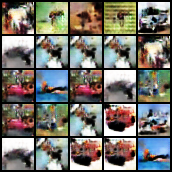

In [ ]:
from IPython.display import Image
Image("99000.png")

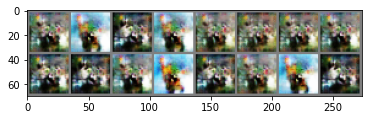

Class : plane


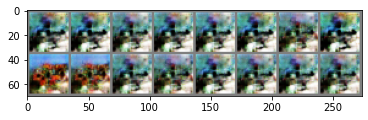

Class : car


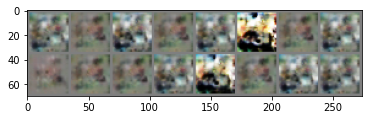

Class : bird


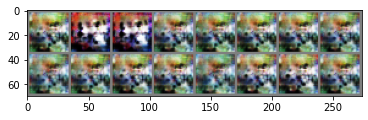

Class : cat


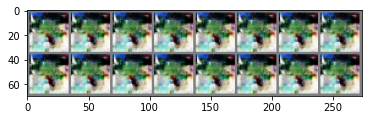

Class : deer


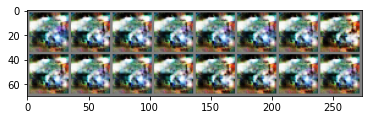

Class : dog


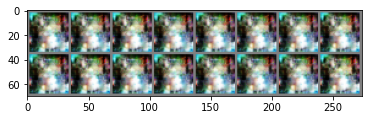

Class : frog


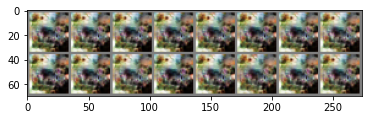

Class : horse


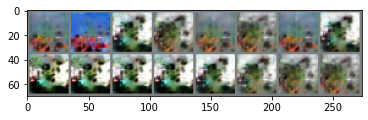

Class : ship


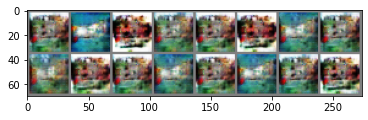

Class : truck


In [ ]:
# 각 클래스별로 생성된 이미지 4개씩 출력하기
for i in range(num_classes):
  z = torch.normal(mean = 0, std = 1, size = (16, latent_dim)).to(device)
  labels = torch.zeros(16, num_classes).to(device)
  labels[:, i] = 1

  generated_imgs = generator(z, labels)
  
  # 이미지 출력하기
  imshow(torchvision.utils.make_grid(generated_imgs.cpu()))
  # 클래스 출력하기
  print(f"Class : {classes[i]}")